<a href="https://colab.research.google.com/github/angadbajwa23/Brain-Image-Segmentation/blob/master/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd gdrive/My Drive/2d

/content/gdrive/My Drive/2d


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import random as r
import math
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from tensorflow.keras.callbacks import  ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

Using TensorFlow backend.


In [0]:
!pip install hdf5storage

     |████████████████████████████████| 61kB 2.1MB/s 


Importing Libraries


In [0]:
import os
import argparse
import sys
import numpy as np
import hdf5storage
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


In [0]:
labels = np.load('labels.npy')
images = np.load('images.npy')
masks = np.load('masks.npy')

In [0]:
images = images[..., np.newaxis]

In [0]:
masks = masks[..., np.newaxis]

Normalizing the Images


In [0]:
for i in range(images.shape[0]):
  images[i,:, :] = (images[i,:, :] - np.mean(images[i,:, :]))/ np.std(images[i,:, :])

Evaluation Metrics

In [0]:
from keras.losses import binary_crossentropy
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

Splitting the dataset into Training, Validation and Test Set

In [0]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_test, images_cv, masks_test, masks_cv = train_test_split(images_test,masks_test,test_size = 0.5,train_size =0.5,random_state=1)

In [0]:
print ("number of training examples = " + str(images_train.shape[0]))
print ("number of development examples = " + str(images_cv.shape[0]))
print ("number of test examples = " + str(images_test.shape[0]))
print ("Images_train shape: " + str(images_train.shape))
print ("Masks_train shape: " + str(masks_train.shape))
print ("Images_val (dev) shape: " + str(images_cv.shape))
print ("Masks_val (dev) shape: " + str(masks_cv.shape))
print ("Images_test shape: " + str(images_test.shape))
print ("Masks_test shape: " + str(masks_test.shape))

number of training examples = 2451
number of development examples = 307
number of test examples = 306
Images_train shape: (2451, 512, 512, 1)
Masks_train shape: (2451, 512, 512, 1)
Images_val (dev) shape: (307, 512, 512, 1)
Masks_val (dev) shape: (307, 512, 512, 1)
Images_test shape: (306, 512, 512, 1)
Masks_test shape: (306, 512, 512, 1)


Model


In [0]:
def unet(input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss='binary_crossentropy', metrics=[dice_coef])

    model.summary()
    return model

To save chekpoints

In [0]:
filepath="cnn-parameters-improvement-{epoch:02d}-{dice_coef:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor=[dice_coef], verbose=1, save_best_only=True, mode='max'))

Training the model


In [0]:
model=unet()
model.fit(images_train, masks_train, batch_size=2, nb_epoch=30, verbose=1,validation_data=(images_cv,masks_cv), callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 512, 512, 64) 640         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_146 (Conv2D)             (None, 512, 512, 64) 36928       conv2d_145[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D) (None, 256, 256, 64) 0           conv2d_146[0][0]                 
____________________________________________________________________________________________

In [0]:
model.save('trained_model')

In [0]:
results = model.evaluate(images_test, masks_test, batch_size=2)
print('dice_coeff:', results)

306/306 [==============================] - 30s 99ms/step
dice_coeff: [0.04224755281043768, 0.654554009437561]


Training the model a bit more!

In [0]:
model.fit(images_train, masks_train, batch_size=2, nb_epoch=3, verbose=1,validation_data=(images_cv,masks_cv), callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 2451 samples, validate on 307 samples
Epoch 1/3
2451/2451 [==============================] - 723s 295ms/step - loss: 0.0057 - dice_coef: 0.8850 - val_loss: 0.0411 - val_dice_coef: 0.6416
Epoch 2/3
2451/2451 [==============================] - 724s 296ms/step - loss: 0.0064 - dice_coef: 0.8737 - val_loss: 0.0470 - val_dice_coef: 0.6279
Epoch 3/3
2451/2451 [==============================] - 724s 296ms/step - loss: 0.0057 - dice_coef: 0.8867 - val_loss: 0.0439 - val_dice_coef: 0.6470


In [0]:
model.fit(images_train, masks_train, batch_size=2, nb_epoch=3, verbose=1,validation_data=(images_cv,masks_cv), callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 2451 samples, validate on 307 samples
Epoch 1/3
2451/2451 [==============================] - 720s 294ms/step - loss: 0.0061 - dice_coef: 0.8793 - val_loss: 0.0528 - val_dice_coef: 0.6230
Epoch 2/3
2451/2451 [==============================] - 724s 296ms/step - loss: 0.0056 - dice_coef: 0.8877 - val_loss: 0.0478 - val_dice_coef: 0.6291
Epoch 3/3
2451/2451 [==============================] - 724s 296ms/step - loss: 0.0050 - dice_coef: 0.8975 - val_loss: 0.0508 - val_dice_coef: 0.6419


In [0]:
model.save('trained_model_1')

In [0]:
dependencies = {
     'dice_coef': dice_coef
}
model = keras.models.load_model('trained_model_1', custom_objects=dependencies)

Evaluating on test set


In [0]:
results = model.evaluate(images_test, masks_test, batch_size=2)
print('loss,dice_coeff:', results)

153/153 [==============================] - 83s 545ms/step - loss: 0.0455 - dice_coef: 0.6727
dice_coeff: [0.04554812237620354, 0.6726678609848022]


Making Predictions

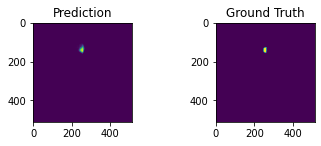

In [0]:
predictions = model.predict(images_train[0:1,:])
plt.subplot(221)
plt.title('Prediction')
plt.imshow(predictions[0,:,:,0])
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(masks_train[0,:,:,0])

Chnaging the loss to bce_dice_loss

In [0]:
def unet(input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss=[bce_dice_loss], metrics=[dice_coef])   

    model.summary()
    return model

In [0]:
model=unet()
model.fit(images_train, masks_train, batch_size=2, nb_epoch=50, verbose=1,validation_data=(images_cv,masks_cv))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_170 (Conv2D)             (None, 512, 512, 64) 640         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 512, 512, 64) 36928       conv2d_170[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_29 (MaxPooling2D) (None, 256, 256, 64) 0           conv2d_171[0][0]                 
____________________________________________________________________________________________

In [0]:
model.save('trained_model_4.h5')

In [0]:

dependencies = {
     'dice_coef': dice_coef,
     'bce_dice_loss': bce_dice_loss
}
model = keras.models.load_model('trained_model_4.h5',custom_objects=dependencies)

In [0]:
results = model.evaluate(images_test, masks_test, batch_size=2)
print('dice_coeff:', results)

153/153 [==============================] - 77s 505ms/step - loss: 0.3920 - dice_coef: 0.6663
dice_coeff: [0.39204278588294983, 0.6662623882293701]
